In [299]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.layers import Input,Dense, Dropout
from keras.models import Model,Sequential
from sklearn.metrics import roc_curve, auc


### Link to Paper

https://arxiv.org/pdf/1809.10717.pdf

In [300]:
DATA_DIR = '/Users/PeterC/Documents/gt/practicum/autoencoders/data/'
DATA_DIR = '/Users/chenpete/Documents/ESP/practicum/autoencoders/data/'

In [301]:
df = pd.read_csv(DATA_DIR + 'paper_mill_rare_events.csv')
df['time'] = pd.to_datetime(df['time'])

## Lots of class imbalance (rare events)

In [302]:
df['y'].value_counts()

0    18274
1      124
Name: y, dtype: int64

### Move Up Y label by 2 increments - 4 minutes before failure

In [303]:
early_step = 3
df['y_early'] = 0
df['y_rank'] = -1
df['y_count'] = np.nan

failure_count = 1
for i in range(df.shape[0]):
    if df.iloc[i]['y'] == 1:
        df.loc[i-early_step:i,'y_early'] = 1
        df.loc[i-early_step:i,'y_rank'] = np.arange(early_step,-1,-1)
        df.loc[i-early_step:i,'y_count'] = failure_count
        failure_count += 1

In [304]:
df['y_rank'].value_counts()

-1    17905
 3      124
 2      124
 1      123
 0      122
Name: y_rank, dtype: int64

df['y_rank'] = np.nan
df['y_count'] = np.nan
failure_length= 10
failure_count = 1

for i in range(df.shape[0]):
    if df.iloc[i]['y'] == 1:
        df.loc[i-failure_length+1:i,'y'] = 1
        df.loc[i-failure_length+1:i,'y_rank'] = np.arange(failure_length,0,-1)
        df.loc[i-failure_length+1:i,'y_count'] = failure_count
        failure_count += 1

# XGBoost Feature Importance 

In [389]:
import xgboost 

x_cols = [
        'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
       'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19',
       'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29',
       'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39',
       'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49',
       'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59',
       'x60','x61'
]
y_cols = ['y']

X = df[x_cols]
y = df[y_cols]

xgb = xgboost.XGBClassifier()
xgb.fit(X,y)

/Users/chenpete/Documents/code/DL/dlenv/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chenpete/Documents/code/DL/dlenv/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [395]:
xgb.

array([0.01156184, 0.05228966, 0.05350589, 0.        , 0.01154085,
       0.01052971, 0.01166753, 0.0185542 , 0.01871878, 0.01571882,
       0.00431626, 0.00505833, 0.00871428, 0.        , 0.00890661,
       0.01079178, 0.01592784, 0.01320933, 0.01414616, 0.        ,
       0.01362442, 0.01600296, 0.01814787, 0.00289612, 0.01938068,
       0.01280246, 0.01091093, 0.        , 0.01607691, 0.03366099,
       0.00559392, 0.0211334 , 0.0115699 , 0.02089728, 0.00818038,
       0.02608267, 0.02101631, 0.0239257 , 0.02193749, 0.01818523,
       0.0064318 , 0.01769689, 0.        , 0.01046038, 0.00993449,
       0.00642605, 0.01509376, 0.01072589, 0.03334501, 0.0127746 ,
       0.        , 0.01031271, 0.00826592, 0.01072843, 0.01059668,
       0.0151467 , 0.01198754, 0.0100049 , 0.00985269, 0.01874009,
       0.16429196], dtype=float32)

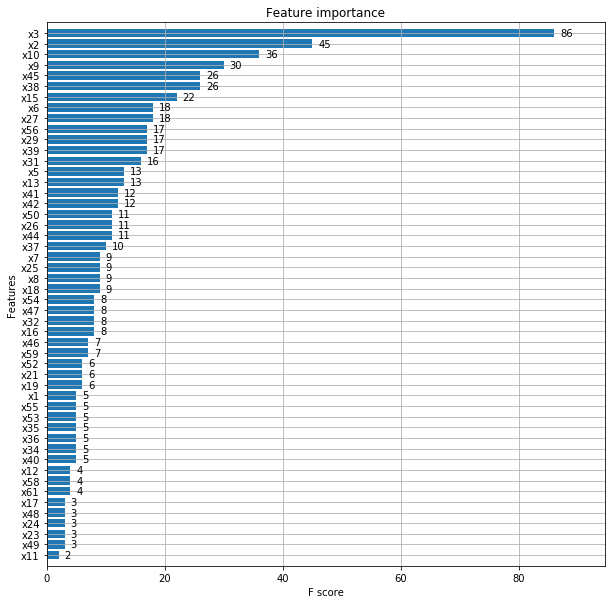

In [394]:
fig, ax = plt.subplots(figsize=(10,10))
xgboost.plot_importance(xgb, max_num_features=50, height=0.8, ax=ax)
plt.show()

## Scale datasets with standard scaler

In [402]:
non_scale_cols = ['time','y_early','y_rank','y_count']
param_cols = [
        'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
       'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19',
       'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29',
       'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39',
       'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49',
       'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59',
       'x60','x61'
]

param_cols = ['x3','x2','x10','x9','x45','x38','x15','x6','x27','x56','x29','x31']

sc = StandardScaler()
df_scaled = pd.DataFrame(data = sc.fit_transform(df[param_cols]),columns=param_cols)
df_scaled = pd.concat([df[non_scale_cols],df_scaled],axis=1)

In [403]:
df_scaled['y_rank'].value_counts()

-1    17905
 3      124
 2      124
 1      123
 0      122
Name: y_rank, dtype: int64

### Plot standard scaled

%%capture
for col in param_cols:
    plt.figure(figsize=(15,5))
    plt.plot(df_scaled[col])
    for val in list(df_scaled[df_scaled['y']==1].index):
        plt.axvline(val,color='red',linewidth=.2)
    plt.xticks(rotation=45)
    plt.title(col)
    plt.savefig(DATA_DIR +'plots/std_scaled_{}.png'.format(col))

In [404]:
X_nominal = df_scaled[df_scaled['y_early'] == 0][param_cols]
X_event = df_scaled[df_scaled['y_early'] == 1][param_cols]


y_nominal = df_scaled[df_scaled['y_early'] == 0]['y_early']
y_event = df_scaled[df_scaled['y_early'] == 1]['y_early']

y_rank_nominal = df_scaled[df_scaled['y_early'] == 0]['y_rank']
y_rank_event = df_scaled[df_scaled['y_early'] == 1]['y_rank']

y_count_nominal = df_scaled[df_scaled['y_count'].isna()]['y_count']
y_count_event = df_scaled[df_scaled['y_count'] >= 1]['y_count']

In [405]:
X_train, X_test, y_train, y_test,y_rank_train, y_rank_test,y_count_train, y_count_test = train_test_split(X_nominal, y_nominal, y_rank_nominal,y_count_nominal, test_size=0.05, random_state=0)

In [406]:
X_test = X_test.append(X_event)
y_test = y_test.append(y_event)
y_rank_test = y_rank_test.append(y_rank_event)
y_count_test = y_count_test.append(y_count_event)

In [432]:
def simple_ann_autoencoder_regression():
    model = Sequential()
    #model.add(Dense(units = 32,activation='relu',input_shape = (len(param_cols),)))
    #model.add(Dense(units = 16,activation='relu',input_shape = (len(param_cols),)))
    model.add(Dense(units = 8,activation='relu',input_shape = (len(param_cols),)))
    model.add(Dense(units = 4,activation='relu',input_shape = (len(param_cols),)))
    model.add(Dense(units = 8,activation='relu',input_shape = (len(param_cols),)))
    #model.add(Dense(units = 16,activation='relu',input_shape = (len(param_cols),)))
    #model.add(Dense(units = 32,activation='relu',input_shape = (len(param_cols),)))
    model.add(Dense(units = len(param_cols),activation='linear'))
    model.compile(optimizer='adam', loss='mse')
    return model

In [433]:
def results_df(X_true,X_pred,y_test,y_rank,y_count):
    residual = X_pred - X_true
    residual_avg = np.abs(np.mean(residual,axis=1))
    df = pd.DataFrame(data = {'residual_avg':residual_avg,
                              'y':y_test,
                              'y_rank':y_rank,
                              'y_count':y_count
                             }
                     )
    return df

def plot_results_hist(df_results):
    plt.figure()
    sns.distplot(df_results[df_results['y']==1]['residual_avg'],norm_hist=True)
    sns.distplot(df_results[df_results['y']==0]['residual_avg'],norm_hist=True)
    plt.legend(['event_residuals_avg','nominal_residuals_avg'])
    plt.title('distribution of average residuals')
    
def plot_results_violin(df_results):
    plt.figure()
    sns.violinplot(x='y',y='residual_avg',data=df_results)

# Model 1: Layer autoencoder - standard scaler (regression

In [434]:
model = simple_ann_autoencoder_regression()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_48 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_49 (Dense)             (None, 8)                 40        
_________________________________________________________________
dense_50 (Dense)             (None, 12)                108       
Total params: 288
Trainable params: 288
Non-trainable params: 0
_________________________________________________________________


In [435]:
history_callback = model.fit(X_train,X_train,epochs=30,batch_size = 12)
loss_history = history_callback.history['loss']

Epoch 1/30
17009/17009 [==============================] - 2s 104us/step - loss: 0.6977
Epoch 2/30
17009/17009 [==============================] - 1s 75us/step - loss: 0.4139
Epoch 3/30
17009/17009 [==============================] - 1s 69us/step - loss: 0.3560
Epoch 4/30
17009/17009 [==============================] - 1s 70us/step - loss: 0.3321
Epoch 5/30
17009/17009 [==============================] - 1s 70us/step - loss: 0.3185
Epoch 6/30
17009/17009 [==============================] - 1s 72us/step - loss: 0.3086
Epoch 7/30
17009/17009 [==============================] - 1s 71us/step - loss: 0.2997
Epoch 8/30
17009/17009 [==============================] - 1s 77us/step - loss: 0.2926
Epoch 9/30
17009/17009 [==============================] - 1s 79us/step - loss: 0.2873
Epoch 10/30
17009/17009 [==============================] - 1s 73us/step - loss: 0.2833
Epoch 11/30
17009/17009 [==============================] - 1s 69us/step - loss: 0.2804
Epoch 12/30
17009/17009 [==========================

Text(0.5, 1.0, 'loss history')

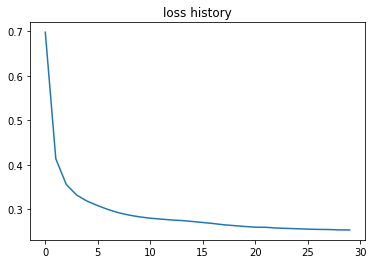

In [436]:
plt.plot(loss_history)
plt.title('loss history')

In [437]:
X_pred_test = model.predict(X_test)

In [438]:
X_pred_train = model.predict(X_train)

In [439]:
X_pred_test.shape

(1389, 12)

In [440]:
df_results_test = results_df(X_test,X_pred_test,y_test,y_rank_test,y_count_test)
df_results_train = results_df(X_train,X_pred_train,y_train,y_rank_train,y_count_train)

In [441]:
df_results_test['y_rank'].value_counts()

-1    896
 3    124
 2    124
 1    123
 0    122
Name: y_rank, dtype: int64

## Assess errors for each time lag

In [442]:
res_nominal_train = df_results_train[df_results_train['y'] == 0]['residual_avg']

average_res_nominal_train = np.mean(res_nominal_train)
std_res_nominal_train = np.std(res_nominal_train)
threshold_3s = average_res_nominal_train + 2*std_res_nominal_train
threshold_3s 

0.16690267515768362


------------------ early time step of 0----------------------------


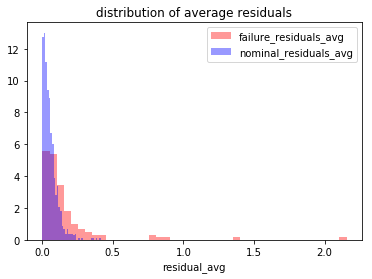

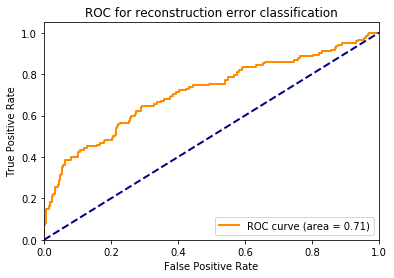

% of nominal accuracy with 3s threshold is 96.09% = 861/896
% of failure accuracy with 3s threshold is 25.41% = 31/122
precision = 0.470
recall = 0.254
f1 = 0.330

------------------ early time step of 1----------------------------


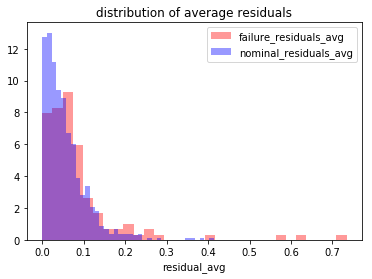

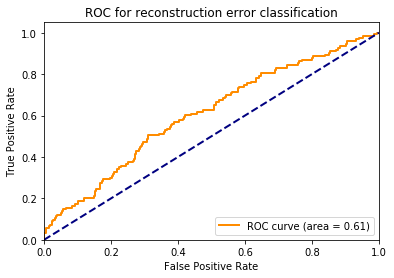

% of nominal accuracy with 3s threshold is 96.09% = 861/896
% of failure accuracy with 3s threshold is 12.20% = 15/123
precision = 0.300
recall = 0.122
f1 = 0.173

------------------ early time step of 2----------------------------


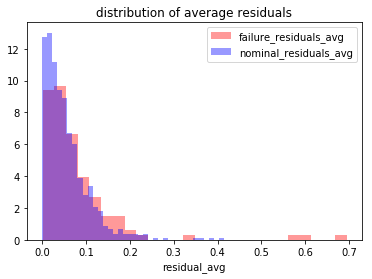

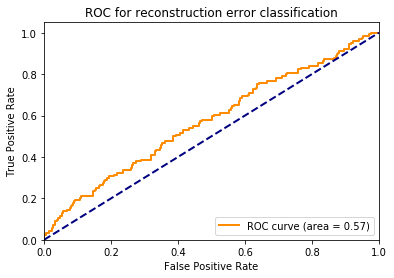

% of nominal accuracy with 3s threshold is 96.09% = 861/896
% of failure accuracy with 3s threshold is 8.87% = 11/124
precision = 0.239
recall = 0.089
f1 = 0.129

------------------ early time step of 3----------------------------


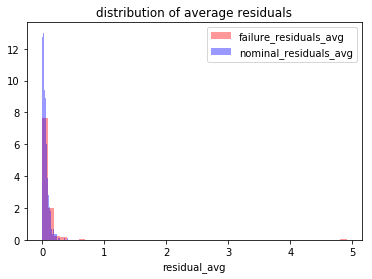

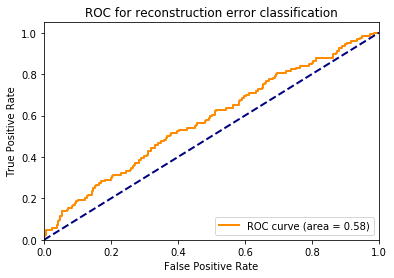

% of nominal accuracy with 3s threshold is 96.09% = 861/896
% of failure accuracy with 3s threshold is 7.26% = 9/124
precision = 0.205
recall = 0.073
f1 = 0.107


In [443]:
for rank in range(early_step+1):
    
    print('\n------------------ early time step of {}----------------------------'.format(rank))
    
    df_results_rank= df_results_test[(df_results_test['y_rank']==rank) | (df_results_test['y_rank']==-1)]
    
    plt.figure()
    sns.distplot(df_results_rank[df_results_rank['y_rank']==rank]['residual_avg'],norm_hist=True,kde=False,color='red')
    sns.distplot(df_results_rank[df_results_rank['y']==0]['residual_avg'],norm_hist=True,kde=False,color='blue')
    
    plt.legend(['failure_residuals_avg','nominal_residuals_avg'])
    plt.title('distribution of average residuals')

    y_true = np.array(df_results_rank['y'])
    y_pred = np.array(df_results_rank['residual_avg']/np.max(df_results_rank['residual_avg']))

    fpr, tpr, thresholds = roc_curve(y_true,y_pred)
    roc_auc = auc(fpr,tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for reconstruction error classification')
    plt.legend(loc="lower right")
    plt.show()
    
    res_nominal = df_results_rank[df_results_rank['y'] == 0]['residual_avg']
    res_event = df_results_rank[df_results_rank['y_rank'] == rank]['residual_avg']
    TP = res_event[res_event>threshold_3s].shape[0]
    FP = res_nominal[res_nominal>threshold_3s].shape[0]
    TN = res_nominal[res_nominal<threshold_3s].shape[0]
    FN = res_event[res_event<threshold_3s].shape[0]

    total_nominal = TN + FP
    total_failure = TP + FN

    precision =TP/(TP+FP)
    recall = TP/(TP+FN)
    f1 = 2*(precision*recall)/(precision+recall)

    print('% of nominal accuracy with 3s threshold is {:.2%} = {}/{}'.format(TN/total_nominal,TN,total_nominal))
    print('% of failure accuracy with 3s threshold is {:.2%} = {}/{}'.format(TP/total_failure,TP,total_failure))
    
    print('precision = {:.3f}'.format(precision))
    print('recall = {:.3f}'.format(recall))
    print('f1 = {:.3f}'.format(f1))

(0, 0.75)

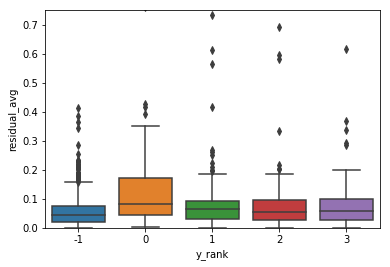

In [444]:
sns.boxplot(x='y_rank',y='residual_avg',data=df_results_test)
plt.ylim((0,.75))

([<matplotlib.axis.XTick at 0x1587d9320>,
 <a list of 4 Text xticklabel objects>)

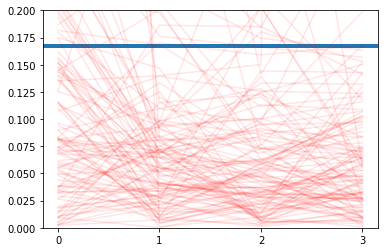

In [445]:
plt.figure()
plt.axhline(threshold_3s,linewidth = 4)
plt.ylim((0,.2))
failure_trigger = 0
for val in df_results_test['y_count'].unique():
    if val > 0:
        df_failure = df_results_test[df_results_test['y_count'] == val]
        plt.plot(df_failure['y_rank'],df_failure['residual_avg'],alpha=.1,color='red')

plt.xticks([0,1,2,3])